transfer learning between a 1Dgamma and a logistic function with the parameters of the first layer fixed 

In [1]:
from scipy.special import kl_div,rel_entr
import numpy as np
from matplotlib import pyplot
import quantum_classical_1Dgamma as qc

import tensorflow as tf
from matplotlib import pyplot
from qibo import gates, hamiltonians, models, set_backend, set_threads

[Qibo 0.1.6|INFO|2022-03-22 21:04:12]: Using numpy backend on /CPU:0
[Qibo 0.1.6|WARNING|2022-03-22 21:04:12]: numpy backend uses `np.einsum` and supports CPU only. Consider installing the qibojit or qibotf backends for increased performance and to enable GPU acceleration.
[Qibo 0.1.6|INFO|2022-03-22 21:04:13]: Using tensorflow backend on /device:CPU:0
[Qibo 0.1.6|WARNING|2022-03-22 21:04:13]: `set_threads` is not supported by the tensorflow backend. Please use tensorflow's thread setters: `tf.config.threading.set_inter_op_parallelism_threads` or `tf.config.threading.set_intra_op_parallelism_threads` to switch the number of threads.


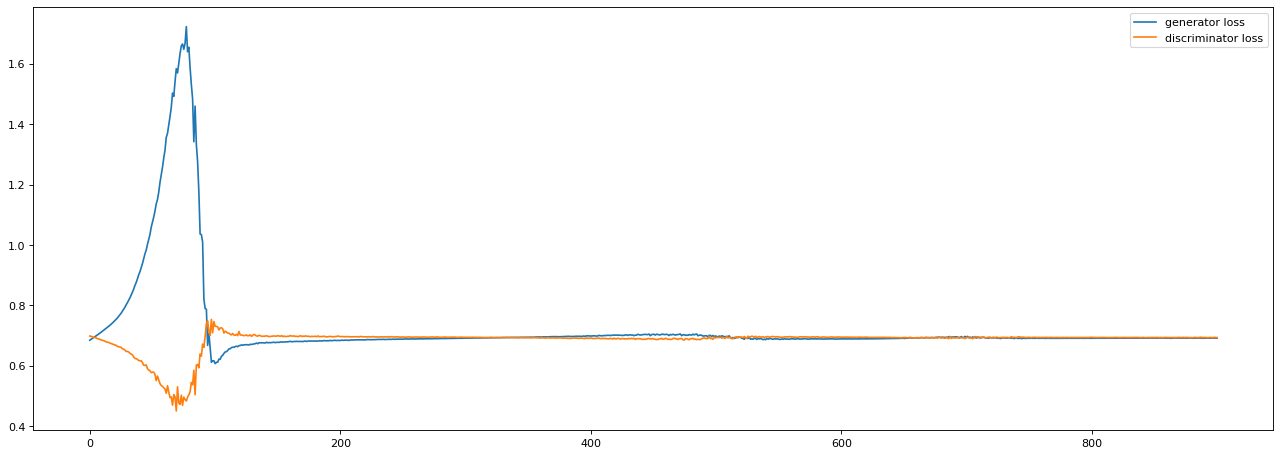

In [2]:
n_layers=128
d_loss = np.loadtxt(f"dloss_1Dgamma_1_3_2_10000_{n_layers}_0.1", delimiter=' ')
g_loss= np.loadtxt(f"gloss_1Dgamma_1_3_2_10000_{n_layers}_0.1", delimiter=' ')
pyplot.figure(figsize=(20, 7), dpi=80)
pyplot.plot(np.linspace(0, len(g_loss), len(g_loss)), g_loss, label='generator loss')
pyplot.plot(np.linspace(0, len(g_loss), len(g_loss)), d_loss, label='discriminator loss')
pyplot.legend()

pyplot.show()


In [8]:
def hamiltonian1():
        m0 = hamiltonians.Z(1).matrix
        ham = hamiltonians.Hamiltonian(1, m0)
        return ham
    
# number of qubits generator
nqubits = 1
# create hamiltonians
hamiltonian1 = hamiltonian1()

latent_dim=3
samples=3000
nqubits=1
layers=2
# create quantum generator
circuit = models.Circuit(nqubits)
for l in range(layers):
    for q in range(nqubits):
        circuit.add(gates.RY(q, 0))
        circuit.add(gates.RZ(q, 0))
for q in range(nqubits):
    circuit.add(gates.RY(q, 0))  

params = np.loadtxt(f"PARAMS_1Dgamma_1_3_2_10000_{n_layers}_0.1", delimiter=' ', unpack='true')
params = tf.Variable(params)
print(params)
x_fake, y_fake = qc.generate_fake_samples(params, latent_dim, samples, circuit, nqubits, layers, hamiltonian1)

<tf.Variable 'Variable:0' shape=(6,) dtype=float64, numpy=
array([-0.18073091, -0.71193462, -0.07029036, -0.01893717,  0.03098666,
       -0.78193218])>


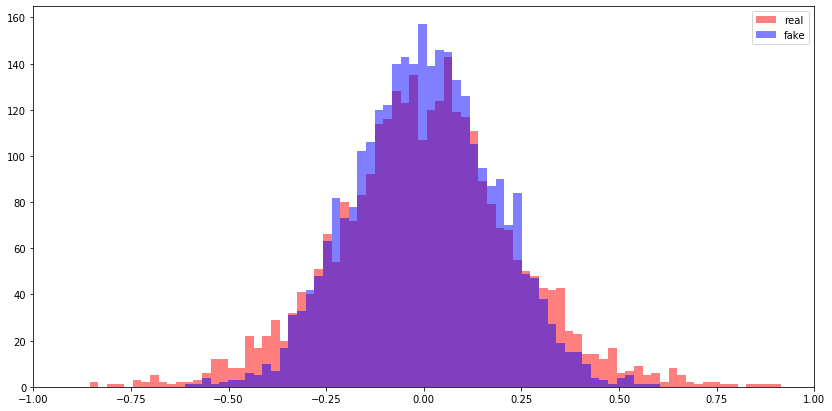

In [9]:
#x_fake,_= qc2.generate_fake_samples(params, latent_dim, samples)
x_real=qc.generate_training_real_samples(samples)

nbins=100
pyplot.figure(figsize=(14, 7))
bins_real=pyplot.hist(x_real, color='red', bins=nbins,label='real', alpha=0.5)
bins_fake=pyplot.hist(x_fake.numpy(), bins=bins_real[1],color='blue', label='fake', alpha=0.5)
pyplot.xlim(-1,1)
pyplot.legend()
pyplot.show()

In [10]:
def kl_divergence(bins_real, bins_fake,epsilon):
    
    epsilon=0.1
    prob_real=[]
    prob_fake=[]
    for i in range (len(bins_real)):
        prob_real.append(bins_real[i]+epsilon)
        prob_fake.append(epsilon+bins_fake[i])

    #print(prob_fake,prob_real)  

    prob_real=prob_real/sum(prob_real) # probability for each bin (Normalization)
    prob_fake=prob_fake/sum(prob_fake)

   
    return sum(prob_real[i] * np.log(prob_real[i]/prob_fake[i]) for i in range(len(prob_real)))# Convergence problem if a[i] or b[i] equals zero. 
                                                            #I add a little quantity to each bin to avoid problems


#print(prob_fake,prob_real)
print("KL DIVERGENCE:",kl_divergence(bins_real[0],bins_fake[0],epsilon=0.1))

KL DIVERGENCE: 0.10715001017439564


KL DIVERGENCE MEAN: 0.1447168386480311


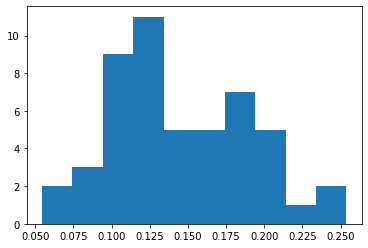

In [7]:
samples=200
kl_mean= []
nbins=20

x_real=qc.generate_training_real_samples(samples)


kl=[]
for i in range (50):
    
    x_fake,_ = qc.generate_fake_samples(params, latent_dim, samples, circuit, nqubits, layers, hamiltonian1)
    
    bins_fake=np.histogram(x_fake, bins=nbins)
    bins_real=np.histogram(x_real,bins=bins_fake[1])
    

    kl.append(kl_divergence(bins_real[0],bins_fake[0],0.1))
    
              
kl_mean = sum(kl)/len(kl) # mean of KL 

pyplot.hist(kl)

print ("KL DIVERGENCE MEAN:",kl_mean)

KL DIVERGENCE: 0.030211258725846433


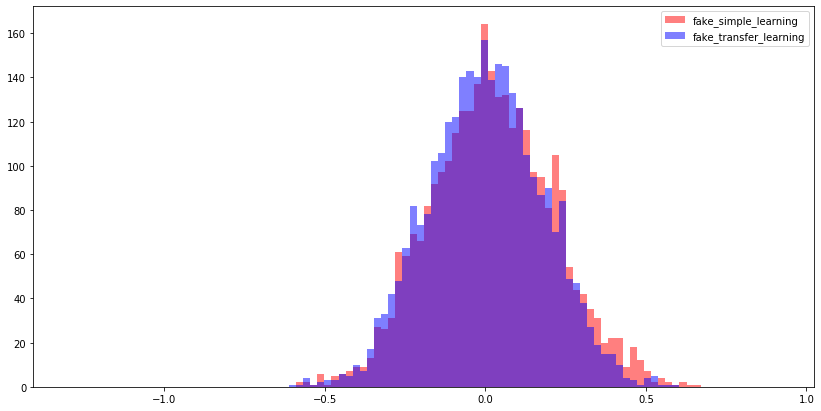

In [11]:
data=np.loadtxt('fake_data.dat')

pyplot.figure(figsize=(14, 7))

bins_data=pyplot.hist(data, bins=bins_real[1],color='red',label='fake_simple_learning', alpha=0.5)
bins_fake=pyplot.hist(x_fake.numpy(), bins=bins_real[1],color='blue', label='fake_transfer_learning', alpha=0.5)

print("KL DIVERGENCE:",kl_divergence(bins_data[0],bins_fake[0],epsilon=0.1))


pyplot.legend()
pyplot.show()